In [31]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import gridspec
import sys
import pandas as pd
import seaborn as sns
import networkx as nx
import yaml
import os
from networkx.algorithms import approximation as nx_approx
from tqdm.notebook import tqdm
from copy import deepcopy
# Adding path to module
sys.path.append("../")
# picture path
PICS = '../pics/'
import scipy.stats
# Module imports
from contagion import Contagion, config
from contagion.config import _baseconfig
from contagion.plotting import plot_infection_history
from contagion.pdfs import construct_pdf
from distributed import Client
import itertools
from matplotlib.backends.backend_pdf import PdfPages
import os
import pickle
from tqdm.notebook import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
cpp_config = {
    "DaysBackwardTrace": 7, 
    "TestPositiveProbability": 0.95, 
    "OutputPrefix": "CovidMC_1346", 
    "AppProbability": 0, 
    "DaysToTestResult": 0, 
    "FalsePositiveRate": 0.00, 
    "NDays": 500, 
    "SymptomProbability": 0.2, 
    "SocialDistancingFactor": 1.0, 
    "SocialDistancingTo": 99999, 
    "BackwardTracing": True, 
    "dTTest": 5, 
    "PeopleMetPerDay": 10.35, 
    "DaysInQuarantine": 14, 
    "TraceUninfected": True, 
    "AsymptomaticTransmissionScaling": 1.0, 
    "StartTracingTestingInfectedFraction": 0, 
    "SocialDistancingFrom": 99999, 
    "TransmissionProbability": 0.0287, 
    "NPersons": 990, 
    "TracingOrder": 1, 
    "IncubationPeriod": {
        "mu": 0, 
        "beta": 2.44, 
        "gamma": 3.06
    }, 
    "TestThreshold": 0.01, 
    "tracingEfficiency": 1.0, 
    "SocialDistancingMaxPeople": 60, 
    "Infectivity": {
        "mu": -2.42, 
        "beta": 1.56, 
        "gamma": 2.08
    }, 
    "TracingDelay": 0, 
    "ReportingProbability": 1.0
}
incub_pdf = scipy.stats.gamma(cpp_config["IncubationPeriod"]["gamma"], scale=cpp_config["IncubationPeriod"]["beta"])
infect_pdf = scipy.stats.gamma(
    cpp_config["Infectivity"]["gamma"],
    scale=cpp_config["Infectivity"]["beta"],
    )

ppl_met_per_day_pdf = scipy.stats.gamma(2, scale=cpp_config["PeopleMetPerDay"]/2)

In [3]:
my_config = dict(_baseconfig)

my_config["general"]["random state seed"] = 6
my_config["general"]["track graph history"] = True
my_config["general"]["debug level"] = 50
my_config["general"]["trace spread"] = True
my_config["general"]["config location"] = "config.yaml"
my_config["general"]["log file handler"] = "contagion.log"

my_config["measures"]["contact tracing"] = True
my_config["measures"]["tracked fraction"] = 0 #cpp_config["AppProbability"]
my_config["measures"]["second order"] = cpp_config["TracingOrder"] == 2
my_config["measures"]["backtrack length"] = cpp_config["DaysBackwardTrace"]+1
my_config["measures"]["track uninfected"] = cpp_config["TraceUninfected"]
my_config["measures"]["quarantine"] = True
my_config["measures"]["report symptomatic"] = True
my_config["measures"]["quarantine duration"] = cpp_config["DaysInQuarantine"]
my_config["measures"]["testing"] = True
my_config["measures"]["time until test"] = 0
my_config["measures"]["time until result"] = cpp_config["DaysToTestResult"]
my_config["measures"]["time until second test"] = cpp_config["dTTest"]+1
my_config["measures"]["time until second test result"] = 0
my_config["measures"]["test true positive rate"] = cpp_config["TestPositiveProbability"]
my_config["measures"]["test false positive rate"] = cpp_config["FalsePositiveRate"]
my_config["measures"]["test threshold"] = cpp_config["TestThreshold"]
my_config["measures"]["app fraction"] = cpp_config["AppProbability"]
my_config["measures"]["random testing mode"] = "standard"
my_config["scenario"]["sim_length"] = 500
my_config['infection']['infected'] = 1
my_config["infection"]["infection probability pdf"] = {
    "class": "Gamma",
    "scaling": (infect_pdf.ppf(0.99))*cpp_config["TransmissionProbability"],
    "mean":  infect_pdf.mean(),
    "sd":  infect_pdf.std()
}
my_config['infection']["hospitalization probability pdf"] = {
    'mean':  0,
    "class": "Delta"
}
my_config['infection']['will have symptoms prob pdf'] = {
    'mean': cpp_config["SymptomProbability"],
    "class": "Delta"
}


my_config["infection"]["infectious duration pdf"] = {
    "mean": np.round(infect_pdf.ppf(0.99)),
    "class": "Delta"
}

my_config["infection"]["latency duration pdf"] = {
    #"mean": -cpp_config["Infectivity"]["mu"],
    #"class": "Delta"
    "upper": np.ceil(-cpp_config["Infectivity"]["mu"]),
    "lower": np.floor(-cpp_config["Infectivity"]["mu"]),
    "class": "Uniform"
}

my_config["infection"]["incubation duration pdf"]["mean"] = incub_pdf.mean()
my_config["infection"]["incubation duration pdf"]["sd"] = incub_pdf.std()
my_config["infection"]["incubation duration pdf"]["as_dtype"] = np.int


my_config["population"]["random interactions pdf"] = {
    "mean": 0.0,
    "class": "Delta"
}

my_config["population"]["random interactions intensity pdf"]= {
    "mean": 0.0,
    "class": "Delta"
}

my_config["infection"]["recovery time pdf"]= {
    "class": "Delta",
    "mean": 0,
}

my_config["population"]["population size"] = cpp_config["NPersons"]


my_config["population"]["nx"]["inter freq pdf"] = {
    "mean": cpp_config["PeopleMetPerDay"],
    "class": "Gamma",
    "mean": ppl_met_per_day_pdf.mean(),
    "sd": ppl_met_per_day_pdf.std(), 
}
my_config["population"]["nx"]["intra freq pdf"] = {
    "mean": cpp_config["PeopleMetPerDay"],
    "class": "Gamma",
    "mean": ppl_met_per_day_pdf.mean(),
    "sd": ppl_met_per_day_pdf.std(), 
}
my_config["population"]["random interactions pdf"] = {"class": "Delta", "mean": 0.000}
my_config["scenario"]["class"] = "LateMeasures"
my_config["scenario"]["start_measures_inf_frac"] = cpp_config["StartTracingTestingInfectedFraction"]
my_config["scenario"]["contact_scaling"] = cpp_config["SocialDistancingFactor"]

ppl_met_per_day_dist_pdf = scipy.stats.gamma(2, scale=my_config["scenario"]["contact_scaling"]*cpp_config["PeopleMetPerDay"]/2)
if cpp_config["StartTracingTestingInfectedFraction"] < 0:
    my_config["scenario"]["social_dist_contact_pdf"] = {
        "class": "Gamma",
        "mean": ppl_met_per_day_dist_pdf.mean(),
        "sd": ppl_met_per_day_dist_pdf.std(),
        "upper": 15
    }
else:
    my_config["scenario"]["social_dist_contact_pdf"] = None
my_config["population"]["population class"] = "NetworkXPopulation"
my_config["population"]["nx"]["func"] = "schools_model"
my_config["population"]["nx"]["kwargs"]["clique_size"] = 30
my_config["population"]["nx"]["kwargs"]["p"] = 0.3
my_config["population"]["nx"]["kwargs"]["pruning_frac"] = 0.5
my_config["population"]["nx"]["kwargs"]["school_symp_prob"] = 0.2
my_config["population"]["nx"]["kwargs"]["family_symp_prob"] = 0.6
my_config["population"]["population storage"] = "/scratch4/chaack/software/scripts/contagion/populations/rel_cave_schools.pickle"

my_config["population"]["random interactions pdf"] = {"class": "Delta", "mean": 0.000}
my_config["scenario"]["class"] = "LateMeasures"
my_config["scenario"]["start_measures_inf_frac"] = cpp_config["StartTracingTestingInfectedFraction"]


In [4]:
def calc_single(conf):
    contagion = Contagion(conf)
    contagion.sim()
    
    # R0 calc
    inf_hist = np.atleast_2d(np.squeeze(np.hstack(contagion.trace_infection)))
    if len(inf_hist) > 0:
        patient_zero = inf_hist[0, 0]
        n_inf = (inf_hist[:, 0] == patient_zero).sum()
    else:
        n_inf = 0
   
    return pd.DataFrame(contagion.statistics), n_inf

def sim_config(conf, n=10):
    results = []
    for i in range(n):
        conf["general"]["random state seed"] = i
        results.append(calc_single(deepcopy(conf)))
    
    return results

    


In [10]:
conf_test = deepcopy(my_config)
conf_test["population"]["re-use population"] = True
results = sim_config(conf_test, 5)

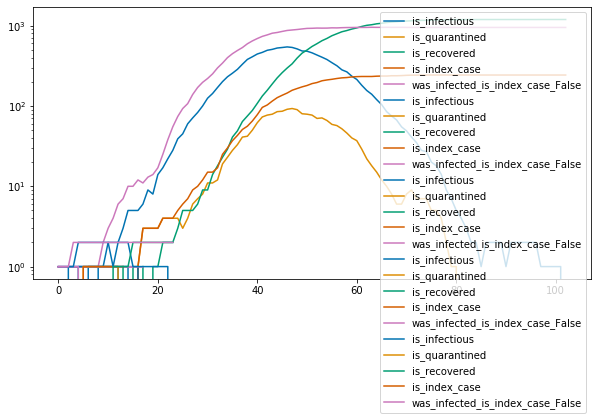

In [14]:
plt.figure(figsize=(10, 5))
colors = sns.color_palette("colorblind", 8)

fields = ["is_infectious", "is_quarantined", "is_recovered", "is_index_case", "was_infected_is_index_case_False"]
for stats in results:
    for field, color in zip(fields, colors):
        plt.plot(stats[0][field], color=color, label=field)
plt.semilogy()
plt.legend()

In [78]:
!rm -rf /scratch4/chaack/data/contagion/runs/5

In [53]:
outpath = "/scratch4/chaack/data/contagion/runs/9/configs"

#os.unlink(my_config["population"]["population storage"])
if not os.path.exists(outpath):
    os.makedirs(outpath)
    
rnd_test_probs = [0, 0.005, 0.01, 0.05]
app_fractions = [0.8, 0.9, 1]
#sdist_scalings = [1, 0.8, 0.6]
symp_probs = [0.1, 0.2, 0.3]
tracing_efficiencies = [0.9, 0.95, 1]
test_pos_rates = [0.95] 
contacts_per_day_means = [5, 15, 20, 30] 

prod_it = itertools.product(app_fractions, rnd_test_probs, symp_probs, tracing_efficiencies, test_pos_rates, contacts_per_day_means)

for i, (app_frac, rnd_test_prob, symp_prob, tr_eff, test_pos_rate, contacts_per_day_mean) in enumerate(prod_it):
    config = my_config
    conf = deepcopy(config)
    sd_scaling = 1
    conf["measures"]["contact tracing"] = app_frac != 0
    conf["measures"]["app fraction"] = app_frac
    conf["measures"]["rnd testing"] = rnd_test_prob != 0
    conf["measures"]["random test num"] = int(rnd_test_prob * conf["population"]["population size"])
    conf["measures"]["test false positive rate"] = 0
    conf["measures"]["backtrack length"] = 7
    conf["measures"]["tracing efficiency"] = tr_eff
    conf["measures"]["test true positive rate"] = test_pos_rate
    conf["measures"]["random testing mode"] = "distribute class"
    conf["population"]["nx"]["kwargs"]["pruning_frac"] = 1-contacts_per_day_mean/30
    #conf["measures"]["random testing mode"] = "standard"
    

    if sd_scaling < 1:
        ppl_met_per_day_dist_pdf = scipy.stats.gamma(2, scale=sd_scaling*cpp_config["PeopleMetPerDay"]/2)
        conf["scenario"]["social_dist_contact_pdf"] = {
            "class": "Gamma",
            "mean": ppl_met_per_day_dist_pdf.mean(),
            "sd": ppl_met_per_day_dist_pdf.std(),
            "upper": 15
        }
    conf["population"]["nx"]["kwargs"]["school_symp_prob"] = symp_prob
    
    """
    if not os.path.exists(conf["population"]["population storage"]):
        print("Pre-builiding pop")
        conf["population"]["store population"] = True
        conf["population"]["re-use population"] = False
        contagion = Contagion(conf)
    conf["population"]["re-use population"] = True
    conf["population"]["store population"] = False
    """
    conf["population"]["re-use population"] = False
    conf["population"]["store population"] = False
        
    yaml.dump(conf, open(os.path.join(outpath, "config_{}.yaml".format(i)), "w"))
        

In [57]:
config = my_config
conf = deepcopy(config)
sd_scaling = 1
conf["measures"]["contact tracing"] = False
conf["measures"]["app fraction"] = 0
conf["measures"]["rnd testing"] = False
conf["measures"]["random test num"] = 0
conf["measures"]["test false positive rate"] = 0
conf["measures"]["backtrack length"] = 7
conf["measures"]["tracing efficiency"] = 0
conf["measures"]["test true positive rate"] = 0.95
conf["measures"]["random testing mode"] = "distribute class"
conf["population"]["nx"]["kwargs"]["pruning_frac"] = 1-20/30
#conf["measures"]["random testing mode"] = "standard"


if sd_scaling < 1:
    ppl_met_per_day_dist_pdf = scipy.stats.gamma(2, scale=sd_scaling*cpp_config["PeopleMetPerDay"]/2)
    conf["scenario"]["social_dist_contact_pdf"] = {
        "class": "Gamma",
        "mean": ppl_met_per_day_dist_pdf.mean(),
        "sd": ppl_met_per_day_dist_pdf.std(),
        "upper": 15
    }
conf["population"]["nx"]["kwargs"]["school_symp_prob"] = 0.2

"""
if not os.path.exists(conf["population"]["population storage"]):
    print("Pre-builiding pop")
    conf["population"]["store population"] = True
    conf["population"]["re-use population"] = False
    contagion = Contagion(conf)
conf["population"]["re-use population"] = True
conf["population"]["store population"] = False
"""
conf["population"]["re-use population"] = False
conf["population"]["store population"] = False

yaml.dump(conf, open("config_no_interv_20ctc.yaml", "w"))
        

In [54]:
data = []
prod_it = itertools.product(app_fractions, rnd_test_probs, symp_probs, tracing_efficiencies, test_pos_rates, contacts_per_day_means)

for i, (app_frac, rnd_test_prob, symp_prob, tr_eff, test_pos_rate, contacts_per_day_mean) in tqdm(enumerate(prod_it)):
    infile = "/scratch4/chaack/data/contagion/runs/9/config_{}.pickle".format(i)
    
    pdata = pickle.load(open(infile, "rb"))["results"]
        
    dframes = [dat[0] for dat in pdata]
    
    res = {
        "app_frac": app_frac,
        "rnd_test_prob": rnd_test_prob,
        "sd_scaling": 1,
        "symp_prob": symp_prob,
        "tracing_eff": tr_eff,
        "test_pos_rate": test_pos_rate,
        "stats": dframes,
        "contacts_per_day": contacts_per_day_mean
    }
    data.append(res)
data = pd.DataFrame(data)

In [55]:
data.to_pickle("run9.pickle", protocol=4)

In [50]:
sel = (data["app_frac"] == 1) & (data["rnd_test_prob"] == 0.005) & (data["symp_prob"] == 0.3) & (data["tracing_eff"] == 1) & (data["test_pos_rate"] == 0.95) & (data["contacts_per_day"] == 15)
np.nonzero(sel.values)

(array([357]),)

In [10]:
import time

'29_Jun_2020_10_40_41'

In [34]:
test = pickle.load(open("/scratch4/chaack/data/contagion/runs/4/config_0.pickle", "rb"))
stats = [res[0] for res in test["results"]]

In [36]:
stats[0]

,contacts,contacts_per_person,num_reported,num_traced,num_traced_infected,num_traced_infectee,num_traced_infected_total,is_removed,is_latent,is_infectious,...,is_tested_positive,is_tested_negative,is_tested_positive_second,is_tested_negative_second,is_index_case,is_reported,is_recovered_is_tested_positive,is_recovered_is_index_case,is_infected_is_quarantined,Re
0,0,0.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.0
1,0,0.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.0
2,0,0.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.0
3,0,0.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.0
4,0,0.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,0,0.0,0,0,0,0,0,969,0,1,...,178,0,0,0,178,0,178,178,0,0.0
85,0,0.0,0,0,0,0,0,969,0,1,...,178,0,0,0,178,0,178,178,0,0.0
86,0,0.0,0,0,0,0,0,969,0,1,...,178,0,0,0,178,0,178,178,0,0.0
87,0,0.0,0,0,0,0,0,969,0,1,...,178,0,0,0,178,0,178,178,0,0.0


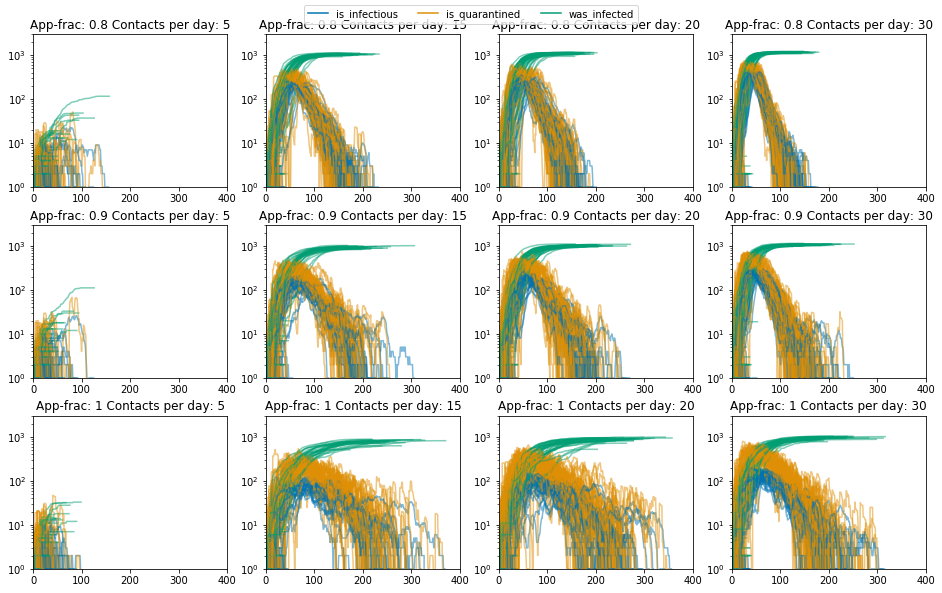

In [56]:
plot_par = app_fractions
plot_par_2 = contacts_per_day_means
fig, axs = plt.subplots(len(plot_par), 4, figsize=(16, len(plot_par)*3))
fields = ["is_infectious", "is_quarantined", "was_infected"]
for (par, par2), ax in zip(itertools.product(plot_par, plot_par_2), axs.ravel()):

    sel = (data["app_frac"] == par) & (data["rnd_test_prob"] == 0.01) & (data["contacts_per_day"] == par2) & (data["symp_prob"] == 0.2) & (data["tracing_eff"] == 1) & (data["test_pos_rate"] == 0.95)

    results = data.loc[sel, "stats"].iloc[0]

    colors = sns.color_palette("colorblind", 8)

   
    for stats in results:
        for field, color in zip(fields, colors):
            ax.plot(stats[field], color=color, label=field, alpha=0.5)
    ax.set_yscale("log")
    ax.set_title("App-frac: {} Contacts per day: {}".format(par, par2))
    ax.set_xlim(0, 400)
    ax.set_ylim(1, 3E3)
    
proxies = [Line2D([], [], label=fields[i], color=colors[i]) for i in range(len(fields))]
fig.legend(proxies, fields, ncol=5, loc="upper center")
fig.subplots_adjust(top=0.95, hspace=0.25)
plt.savefig("schools_comp.png", dpi=150)

In [23]:
len(results)

1

In [43]:
conf = deepcopy(my_config)
conf["population"]["re-use population"] = False
conf["measures"]["test true positive rate"] = 0.95
conf["measures"]["rnd testing"] = True
conf["measures"]["random test num"] = 20
conf["general"]["random state seed"] = 10
conf["measures"]["contact tracing"] = True
conf["measures"]["app fraction"] = 1
conf["population"]["nx"]["kwargs"]["pruning_frac"] = 1-5/30
contagion = Contagion(deepcopy(conf))
contagion.sim()
results = pd.DataFrame(contagion.statistics)
conf["population"]["nx"]["kwargs"]["pruning_frac"] = 1-30/30
contagion = Contagion(deepcopy(conf))
contagion.sim()
results2 = pd.DataFrame(contagion.statistics)

In [74]:
g = contagion.pop._graph
print(len(g))
traced_inf = 0
inf_school = 0
inf_family = set()
traced_inf_school = 0
traced_inf_fam = set()

for node in g:    
    hist = g.nodes[node]["history"]
    if "infected_at" in hist:
        if g.nodes[node]["type"] == "school":
            inf_school += 1
        else:
            inf_family.add(g.nodes[node]["family_index"])
        if "traced" in hist:
            if g.nodes[node]["type"] == "school":
                traced_inf_school += 1
            traced_inf_fam.add(g.nodes[node]["family_index"])
                
                
                
            

2909


In [77]:
print(inf_school, traced_inf_school, len(inf_family), len(inf_family & traced_inf_fam))

538 537 57 57


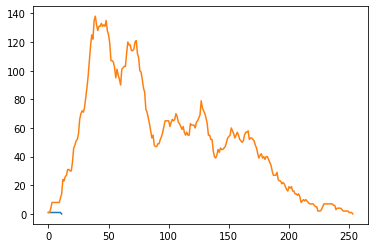

In [44]:
plt.plot(results["is_infected"])
plt.plot(results2["is_infected"])

In [24]:
len(contagion.pop._graph)

2906

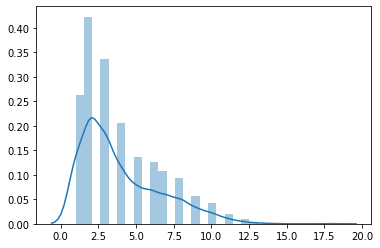

In [37]:
degree_dist = list(dict(contagion.pop._graph.degree).values())
sns.distplot(degree_dist)

In [64]:
np.average(degree_dist)

14.494949494949495